# Zero-inflated Poisson regression and some examples with `statsmodels`

## 1) Theory

The zero-inflated poisson model is a natural choice to model phenomena that are counts but that are characterized by an over-abundance of zeros compared what one would expect from a poisson random-variable. In general one can model this situation is with a mixture between two distributions. In particular (see Cameron and Trivedi (2013), section 4.6), given a base count density $f_2(y_i)$

$$
\begin{align}
\mathbb{P}[y_i=j] = \begin{cases} \pi_i + (1-\pi_i)f_2(0) \;\; \text{if} \; j = 0, \\
(1-\pi_i)f_2(j) \;\;\;\;\;\;\;\;\; \text{if} \; j > 0
\end{cases}
\end{align}
$$

Hence we add a proportion of zeros $\pi_i$ to the baseline distribution and the probabilities from the baseline model are decreased by the proportion $(1-\pi_i)$ to make the probabilities add to one. One can either set $\pi_i$ to a constant (just estimate an intercept) or let it depend on the $\mathbf{x}_i$ e.g. via a logistic regression model.

The model is estimated by maximum likelihood. Define a censoring indicator

$$
\begin{align}
d_i = \begin{cases}1 \;\;\;\; \text{if } y_i > 0, \\
0 \;\;\;\; \text{if } y_i = 0, 
\end{cases}
\end{align}
$$

Note that $d_i= 0$ with probability $\pi_i$ and $d_i=1$ with probability $1-\pi_i$. Hence the density becomes

$$
f(y_i) = [\pi_i + (1-\pi_i)f_2(0)]^{1-d_i}\times[(1-\pi)f_2(y_i)]^{d_i}
$$

If we let the zero-inflation component $\pi_i$ and the base count density $f_2(y_i)$ be functions of the parameter vector $\mathbf{x}_i$, the likelihood can be written as

$$
\begin{align}
L(\mathbf{\theta}_1,\mathbf{\theta}_2|\mathbf{X},\mathbf{Y}) &=  \prod_{i=1}^m[\pi_i(\mathbf{x}_i, \mathbf{\theta}_1) + (1-\pi_i(\mathbf{x}_i, \mathbf{\theta}_1))f_2(0|\mathbf{x}_i,\mathbf{\theta}_2)]^{1-d_i}\times[(1-\pi(\mathbf{x}_i, \mathbf{\theta}_1))f_2(y_i|\mathbf{x}_i,\mathbf{\theta}_2)]^{d_i}
\end{align}
$$

One particular version of such a model is to make $f_2(y_i)$ poisson and model $\pi_i$ with a logit. This is the model considered by Lambert (1992). In particular

$$
\begin{align}
\mathbf{\pi}_i(\mathbf{x}_i,\mathbf{\theta}_1) &= \frac{\mathrm{e}^{\mathbf{\theta_1}'\mathbf{x}_i}}{1+\mathrm{e}^{\mathbf{\theta_1}'\mathbf{x}_i}} \\
f_2(y_i|\mathbf{x}_i, \mathbf{\theta}_2) &= \frac{\mathrm{e}^{y_i\mathbf{\theta}_2'\mathbf{x}_i}\mathrm{e}^{-\mathrm{e}^{\mathbf{\theta}_2'\mathbf{x}_i}}}{y_i!} 
\end{align}
$$

For details on gradient and Hessian of the likelihood, see https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Zero-Inflated_Poisson_Regression.pdf

Cameron and Trivedi (2013) suggest that economic data still suffer from over-dispersion and therefore recommend to use the Negative Binomial model for the base count density. The problem is that this more heavily parameterized model is more difficult to estimate. Hence the convergence of the ML estimation may be slow

## 2) Examples

### 2.1) Example one: weekend drinking

The is a nice example since it gives an explicit motivation for using a mixture. Ask a group of students: "How many drinks did you have this weekend?" The group may contain drinkers and non-drinkers. The non-drinkers never drink (so they are part of the $\pi_i$), but even some of the drinkers may not have had a drink this weekend, so they may also report a zero (their poisson RV had a draw of zero). 

https://bookdown.org/roback/bookdown-bysh/ch-poissonreg.html#cs:drinking

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedPoisson as ZIP

/home/seb/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('./weekendDrinks.csv')

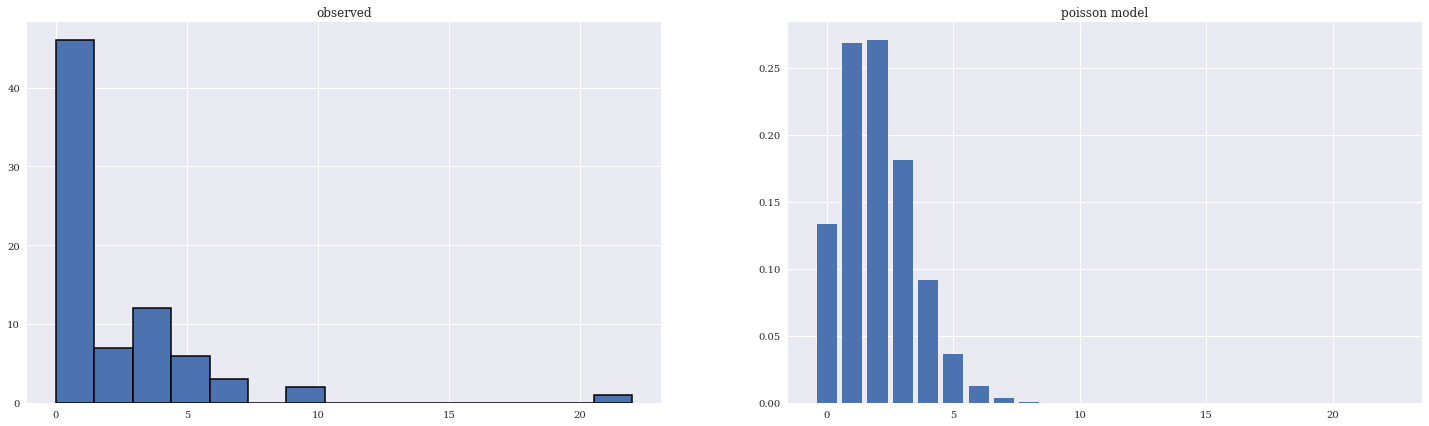

In [3]:
f, ax = plt.subplots(1,2, figsize=(25,7))
ax[0].hist(df.drinks, bins=15, edgecolor="k", linewidth=1.5)
ax[0].set_title('observed')

lamb = df.drinks.mean()
theoretical = np.array([(lamb**k)*np.exp(-lamb) / np.math.factorial(k) for k in range(df.drinks.max()+1)])

ax[1].bar(np.arange(0,df.drinks.max()+1), theoretical)
ax[1].set_title('poisson model')

plt.show()

First, we can fit a simple Poisson model

In [4]:
df['off_campus'] = (df.dorm == 'off campus')
df['male'] = (df.sex == 'm')

In [5]:
endog_var = df.drinks.values
exog_vars = np.concatenate([np.ones(df.shape[0]).reshape(-1,1),
                            df.off_campus.values.reshape(-1,1),
                            df.male.values.reshape(-1,1)],
                           axis=1)
m = sm.GLM(endog = endog_var,
           exog = exog_vars,
           family = sm.families.Poisson()).fit()

In [6]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   77
Model:                            GLM   Df Residuals:                       74
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -175.55
Date:                Fri, 17 Apr 2020   Deviance:                       230.54
Time:                        00:26:38   Pearson chi2:                     254.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1293      0.124      1.041      0.298      -0.114       0.373
x1             0.8976      0.201      4.470      0.000       0.504       1.291
x2             1.1154      0.161      6.925      0.000       0.800       1.431
==============================================================================
"""

In [7]:
print(m.deviance)

230.5439891062946


Looking at the code here https://github.com/proback/BYSH/blob/master/04-Poisson-Regression.Rmd, the `first_year` variable is generated as follows:

In [8]:
df['first_year'] = df.dorm.isin(['kildahl', 'mohn', 'kittlesby'])

In [9]:
endog_var = df.drinks.values
exog_vars = np.concatenate([np.ones(df.shape[0]).reshape(-1,1),
                            df.off_campus.values.reshape(-1,1),
                            df.male.values.reshape(-1,1)],
                           axis=1)
exog_vars_infl = np.concatenate([np.ones(df.shape[0]).reshape(-1,1),
                                 df.first_year.values.reshape(-1,1)],
                                axis=1)
m = ZIP(endog = endog_var,
        exog = exog_vars,
        exog_infl=exog_vars_infl,
        inflation='logit').fit()

Optimization terminated successfully.
         Current function value: 1.828103
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20


/home/seb/py36/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [10]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                       y   No. Observations:                   77
Model:             ZeroInflatedPoisson   Df Residuals:                       74
Method:                            MLE   Df Model:                            2
Date:                 Fri, 17 Apr 2020   Pseudo R-squ.:                  0.1315
Time:                         00:26:38   Log-Likelihood:                -140.76
converged:                        True   LL-Null:                       -162.08
Covariance Type:             nonrobust   LLR p-value:                 5.540e-10
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -0.6036      0.303     -1.992      0.046      -1.198      -0.010
inflate_x1        1.1364      0.609      1.865      0.062      -0.058       2.330
const             0.7543      0.139      5.408      0.000       0.481       1.028
x1                0.4159      0.205      2.026      0.043       0.014       0.818
x2                1.0209      0.172      5.926      0.000       0.683       1.359
=================================================================================
"""

In [11]:
yhat = m.predict(exog=exog_vars, exog_infl=exog_vars_infl)

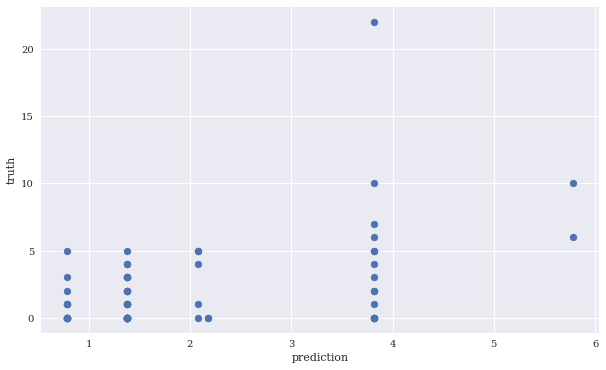

In [12]:
f, ax = plt.subplots(1,1,figsize=(10, 6))
ax.scatter(yhat, df.drinks)
ax.set_xlabel('prediction')
ax.set_ylabel('truth')
plt.show()

### 2.2) Second example: fish caught in state park

Example is taken from here: https://stats.idre.ucla.edu/r/dae/zip/

In [13]:
df = pd.read_csv('https://stats.idre.ucla.edu/stat/data/fish.csv')

In [14]:
df.head()

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1


In [15]:
df.describe()

,nofish,livebait,camper,persons,child,xb,zg,count
count,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000,250.000000
mean,0.296000,0.864000,0.588000,2.52800,0.684000,0.973796,0.252323,3.296000
std,0.457407,0.343476,0.493182,1.11273,0.850315,1.440277,2.102391,11.635028
min,0.000000,0.000000,0.000000,1.00000,0.000000,-3.275050,-5.625944,0.000000
25%,0.000000,1.000000,0.000000,2.00000,0.000000,0.008267,-1.252724,0.000000
50%,0.000000,1.000000,1.000000,2.00000,0.000000,0.954550,0.605079,0.000000
75%,1.000000,1.000000,1.000000,4.00000,1.000000,1.963855,1.993237,2.000000
max,1.000000,1.000000,1.000000,4.00000,3.000000,5.352674,4.263185,149.000000


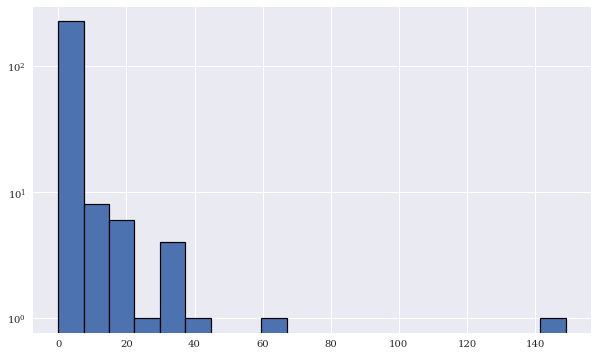

In [16]:
f, ax = plt.subplots(1,1,figsize=(10, 6))

ax.hist(df['count'], bins=20, edgecolor="k", linewidth=1.2)
ax.set_yscale('log')

plt.show()

In [17]:
endog_var = df['count'].values
exog_vars = np.concatenate([np.ones(df.shape[0]).reshape(-1,1),
                            df.child.values.reshape(-1,1),
                            df.camper.values.reshape(-1,1)],
                           axis=1)
exog_vars_infl = np.concatenate([np.ones(df.shape[0]).reshape(-1,1),
                                 df.persons.values.reshape(-1,1)],
                                axis=1)
m = ZIP(endog = endog_var,
        exog = exog_vars,
        exog_infl=exog_vars_infl,
        inflation='logit').fit()

Optimization terminated successfully.
         Current function value: 4.126434
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18


/home/seb/py36/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [18]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                       y   No. Observations:                  250
Model:             ZeroInflatedPoisson   Df Residuals:                      247
Method:                            MLE   Df Model:                            2
Date:                 Fri, 17 Apr 2020   Pseudo R-squ.:                 0.08466
Time:                         00:26:40   Log-Likelihood:                -1031.6
converged:                        True   LL-Null:                       -1127.0
Covariance Type:             nonrobust   LLR p-value:                 3.647e-42
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const     1.2974      0.365      3.554      0.000       0.582       2.013
inflate_x1       -0.5643      0.151     -3.735      0.000      -0.860      -0.268
const             1.5979      0.085     18.797      0.000       1.431       1.765
x1               -1.0428      0.089    -11.660      0.000      -1.218      -0.868
x2                0.8340      0.093      9.000      0.000       0.652       1.016
=================================================================================
"""

Alternative: run the model with robust standard errors -- these are MUCH larger for the parameters of the count component of the model.

In [19]:
m = ZIP(endog = endog_var,
        exog = exog_vars,
        exog_infl=exog_vars_infl,
        inflation='logit').fit(cov_type='HC0')

Optimization terminated successfully.
         Current function value: 4.126434
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18


/home/seb/py36/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [20]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                       y   No. Observations:                  250
Model:             ZeroInflatedPoisson   Df Residuals:                      247
Method:                            MLE   Df Model:                            2
Date:                 Fri, 17 Apr 2020   Pseudo R-squ.:                 0.08466
Time:                         00:26:40   Log-Likelihood:                -1031.6
converged:                        True   LL-Null:                       -1127.0
Covariance Type:                   HC0   LLR p-value:                 3.647e-42
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const     1.2974      0.363      3.570      0.000       0.585       2.010
inflate_x1       -0.5643      0.147     -3.843      0.000      -0.852      -0.277
const             1.5979      0.283      5.647      0.000       1.043       2.152
x1               -1.0428      0.309     -3.374      0.001      -1.649      -0.437
x2                0.8340      0.388      2.148      0.032       0.073       1.595
=================================================================================
"""

In [21]:
yhat = m.predict(exog=exog_vars, exog_infl=exog_vars_infl)

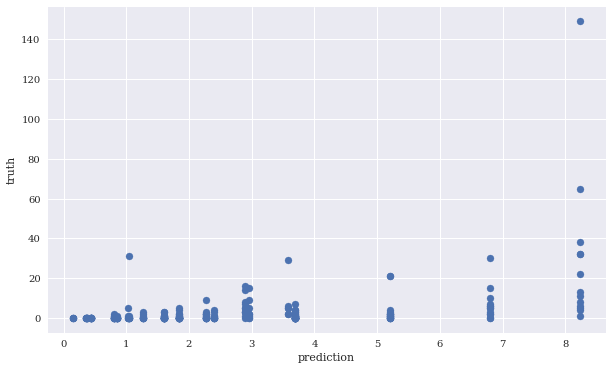

In [22]:
f, ax = plt.subplots(1,1,figsize=(10, 6))
ax.scatter(yhat, df['count'])
ax.set_xlabel('prediction')
ax.set_ylabel('truth')
plt.show()

**TODO** 

- add Vuong tests comparing ZIP to ordinary Poisson regression

- add boostrapped standard errors